In [1]:
using Pkg
Pkg.activate("C:/Users//sbirk//Documents//sciebo//Programmierung//ATIS3_2020//Project.toml") # change path 
Pkg.instantiate()

 Activating environment at `C:\Users\fabia\ATIS3_2020\Project.toml`


In [2]:
using JuMP, LinearAlgebra, Plots, StatsPlots, CPLEX, Statistics, CSV, DataFrames

## Define parameter

In [3]:
#read scenario data
scenarios_hexagons = CSV.read("scenarios_multinomial_4.csv", DataFrame)
scenarios_prices = CSV.read("priceScenarions3.csv", DataFrame)

hexagons = names(scenarios_hexagons)[1:length(names(scenarios_hexagons))-1] # vector of hexagons (strings)
hours = names(scenarios_prices)[3:length(names(scenarios_prices))] #vector of hours for charging (strings)
car_kWh = 30 # capacity of each car

#demand mxn (m=hexagon, n=scenario) in kWh summe über car*max_kWh*(1-SOC)
SOC = Array(CSV.read("SoC_4.csv", DataFrame))
one_mat = ones(size(SOC,1), size(SOC,2))
demand_cars = transpose(convert(Matrix,scenarios_hexagons[:,hexagons]))

demand_kWh = demand_cars.*car_kWh.*(one_mat.-SOC)

#prices mxn (m=hours, n=scenario)
prices = transpose(convert(Matrix,scenarios_prices[:,hours]))
prices = prices/100
# prices[prices.<0] .= 0

probability_hexagons = transpose(scenarios_hexagons.probs) # probabilities for each scenario (#cars per hexagon)
probability_prices = transpose(scenarios_prices.Probability) # probabilities for each scenario (timeseries prices)

P = [3.7, 11, 22] # different charger types in kW
charger_cost_fix = [1500, 1700, 1900] # investment cost for charger 3 kW, 7 kW und 11 kW in €
charger_cost_annuity = charger_cost_fix./(3*365)
charger_cost = charger_cost_annuity./P # investment cost for charger 3 kW, 7 kW und 11 kW in €/kW
opportunity_cost = 37.47 # 47 min * 0,29€ / (17kWh * 2,14%); before:0.4 # cost of demand not served

alpha_ = 0.05
beta = 0

prices

7×7 Array{Float64,2}:
 0.4456   0.2787  0.3763  0.1739  0.5     0.4296  0.5574
 0.426    0.2701  0.3636  0.1651  0.4663  0.417   0.5383
 0.3923   0.198   0.3157  0.0402  0.3928  0.3677  0.4934
 0.3751   0.004   0.3202  0.3144  0.308   0.1765  0.4487
 0.3718  -0.0299  0.301   0.2566  0.3023  0.1286  0.4807
 0.3654  -0.0519  0.2905  0.2405  0.2987  0.1427  0.4749
 0.3578  -0.0745  0.2804  0.2411  0.2871  0.1445  0.4459

## Build the scenario tree

In [4]:
## Build Probabilities
comb_probability = []
for prob_d in probability_hexagons
    for prob_p in probability_prices
        push!(comb_probability,prob_d*prob_p)
    end
end
comb_probability = convert(Array{Float64,1}, comb_probability)

## Build Demand kWh and Demand Cars
num_hex = size(demand_kWh,1)
num_Scen_Dem = size(demand_kWh,2)
num_Scen_Pri = size(prices,2)

comb_demand_kWh = zeros((num_hex, num_Scen_Dem*num_Scen_Pri))
comb_demand_cars = zeros((num_hex, num_Scen_Dem*num_Scen_Pri))
comb_SOC = zeros((num_hex, num_Scen_Dem*num_Scen_Pri))
counter = 0

for num_d in 1:num_Scen_Dem
    for num_p in 1:num_Scen_Pri
        counter += 1
        comb_demand_kWh[:,counter] = demand_kWh[:,num_d]
        comb_demand_cars[:,counter] = demand_cars[:,num_d]
        comb_SOC[:,counter] = SOC[:,num_d]
    end
end

## Build Prices
num_Scen_Dem = size(demand_kWh,2)
num_Scen_Pri = size(prices,2)

comb_prices = zeros((length(hours), num_Scen_Dem*num_Scen_Pri))
counter = 0

for num_d in 1:num_Scen_Dem
    for num_p in 1:num_Scen_Pri
        counter += 1
        comb_prices[:,counter] = prices[1:length(hours),num_p]
    end
end


## Build model

In [5]:
function charger_siting(comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices, 
        comb_probability, P, charger_cost, opportunity_cost, alpha, beta)
    
    opprtunity_cost = 0
    
    # Define Sets
    Γ = Array{Int}(1:length(hexagons)) # Gamma, Set with hexagons
    Σ = Array{Int}(1:length(P)) # Sigma, Set with charger types 
    Ω = Array{Int}(1:length(comb_probability)) # Omega, Set with scenarios
    Τ = Array{Int}(1:length(hours)) # Lambda, Set with scenarios for prices

    # Initialize model    
    m = Model(CPLEX.Optimizer)
    
    # η
    @variable(m, η) 
    @variable(m, 0 <= s[k=Ω])
    β = beta 
    α = alpha
    
    # Define variables
    @variable(m, 0 <= x_charger[i=Γ,j=Σ],Int) # number of specific charger type in each hexagon
    @variable(m, 0 <= E_supplied[i=Γ,j=Σ,k=Ω,t=Τ]) # supplied energy in each hexagon kWh
    @variable(m, 0 <= E_not_supplied[i=Γ,k=Ω])     # demand not covered kWh
    @variable(m, 0 <= cars_supplied[i=Γ,j=Σ,k=Ω],Int)
    @variable(m, 0 <= cars_not_supplied[i=Γ,k=Ω],Int)

    # expressions for total costs
    @expression(m, invest_cost[i=Γ,j=Σ], charger_cost[j].*x_charger[i,j].*P[j]) # first stage investment cost
    @expression(m, charging_opportunity_cost[i=Γ,k=Ω], opportunity_cost.*E_not_supplied[i,k].*comb_probability[k])
    # @expression(m, grid_usage[i=Γ,k=Ω,t=Τ], 0.1*sum(E_supplied[i,j,k,t] for j in Σ)^(2).*comb_probability[k])
    @expression(m, grid_usage[i=Γ,k=Ω,t=Τ], 0.1*sum(E_supplied[i,j,k,t] for j in Σ).*comb_probability[k])
    @expression(m, charging_cost[i=Γ,j=Σ,k=Ω,t=Τ], comb_prices[t,k].*E_supplied[i,j,k,t].*comb_probability[k]) #minimize cost of charging
    
    # expressions for objective function
    @expression(m, total_cost, (-1)*(  sum(invest_cost) 
                                     + sum(charging_cost)
                                     + sum(charging_opportunity_cost) 
                                     + sum(grid_usage)
                                     )
                )
    @expression(m, cVAR, η-(1/(1-α) * dot(comb_probability, s)))
    @objective(m, Max, (1-β)*total_cost + β*cVAR)
    
    # Constraints
    # Eq. Balance equation: Demand in each hexagon has to equal demand. Loss of load is possible
    @constraint(m, eq_balance[i=Γ,k=Ω], sum(E_supplied[i,j,k,t] for j in Σ for t in Τ) + E_not_supplied[i,k] == comb_demand_kWh[i,k])

    # Eq. energy limit: rated_power*chargingtime must not exeed energy
    @constraint(m, eq_cap[i=Γ,j=Σ,k=Ω,t=Τ], E_supplied[i,j,k,t] <= x_charger[i,j].*P[j])

    # Eq. supplied cars and not supplied cars have to equal amount of cars in each hexagon
    @constraint(m, eq_cars_supplied[i=Γ,k=Ω],     sum(cars_supplied[i,j,k] for j in Σ) 
                                                    + cars_not_supplied[i,k]
                                                   == comb_demand_cars[i,k])

    # Eq. maximum one car per charging station
    @constraint(m, eq_max_cars[i=Γ,j=Σ,k=Ω], cars_supplied[i,j,k] <= x_charger[i,j])

    # Eq. 
    @constraint(m, eq_max_supply[i=Γ,j=Σ,k=Ω], sum(E_supplied[i,j,k,t] for t in Τ) == cars_supplied[i,j,k].*car_kWh.*(1-comb_SOC[i,k]))

    # η Constraint
    @constraint(m, cVAR_constraint[k=Ω], η + (sum((charger_cost[j].*x_charger[i,j].*P[j]) for j in Σ for i in Γ) 
                                           +  sum((opportunity_cost.*E_not_supplied[i,k]) for i in Γ)
                                           # +  sum(0.1*sum(E_supplied[i,j,k,t] for j in Σ)^(2) for i in Γ for t in Τ)
                                           +  0.1*sum(E_supplied[i,j,k,t] for j in Σ for i in Γ for t in Τ)
                                           +  sum((comb_prices[t,k].*E_supplied[i,j,k,t]) for j in Σ for i in Γ for t in Τ))
                                           <= s[k])

    # Run optimization
    optimize!(m)

    # Evaluate resuluts
    obj = objective_value(m)
    charger_in_hex = value.(x_charger)
    
    cost1 = value.(sum(invest_cost)) 
    cost2 = value.(sum(charging_cost))
    cost3 = value.(sum(charging_opportunity_cost)) 
    cost4 = value.(sum(grid_usage))
    
    println("cost invest:  ", cost1)
    println("cost charging:  ",cost2)
    println("cost opportunity:  ",cost3)
    println("cost grid:  ",cost4)
    
    res_total_cost = value.(total_cost)
    cvar = value.(cVAR)
    
    return charger_in_hex, E_not_supplied, E_supplied, cars_supplied, res_total_cost, cvar
end

charger_siting (generic function with 1 method)

## Run model Base Case 

In [6]:
charger_in_hex, E_not_supplied, E_supplied, cars_supplied, res_total_cost, cvar = charger_siting(
    comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices, 
        comb_probability, P, charger_cost, opportunity_cost, alpha_, beta)

println(round.(charger_in_hex))
println("cvar:",cvar)
println("total_cost:",res_total_cost)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -419688.580320 after 0.02 sec. (9.36 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 26621 rows and 23940 columns.
MIP Presolve modified 1274 coefficients.
Aggregator did 1169 substitutions.
Reduced MIP has 51002 rows, 45827 columns, and 176302 nonzeros.
Reduced MIP has 832 binaries, 5417 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.13 sec. (126.12 ticks)
Probing time = 0.03 sec. (2.61 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 3976 rows and 3595 columns.
Reduced MIP has 47026 rows, 42232 columns, and 162582 nonzeros.
Reduced MIP has 469 binaries, 5265 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (83.85 ticks)
Probing time = 0.02 sec. (2.33 ticks)
Clique table members: 133.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution 

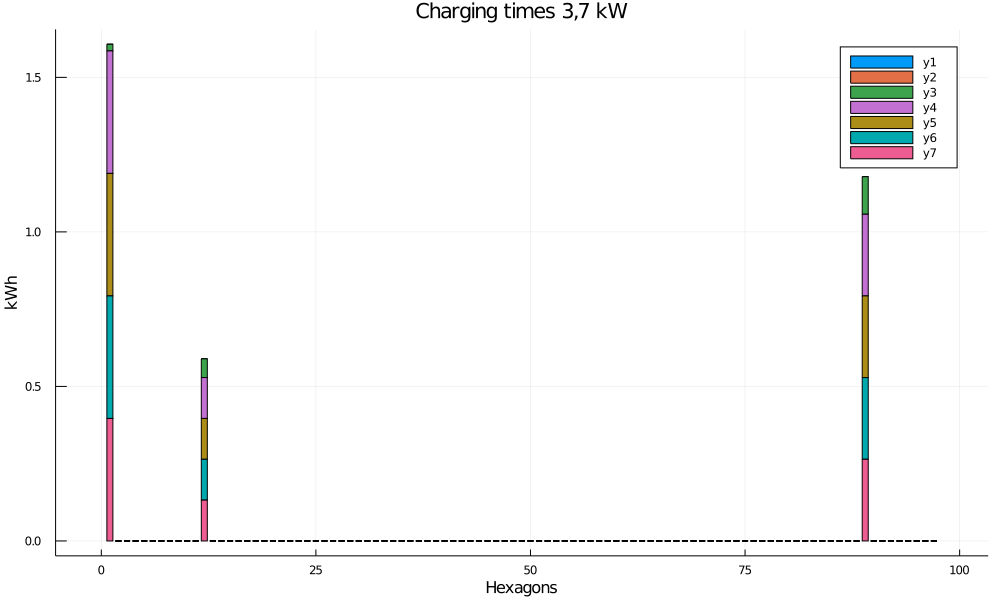

In [56]:
I, J, K, T = axes(value.(E_supplied))
charge_times = zeros(length(T), length(I))

for k in length(K)
    charge_times += transpose([value.(E_supplied[i,1,k,t]) for i in I, t in T])
end

charge_times = charge_times ./ length(K)

gr(size=(1000,600), legend=true)
groupedbar(charge_times',
            bar_position = :stack,
            bar_width=0.7,
            title = "Charging times 3,7 kW",
            xlabel = "Hexagons",
            ylabel = "kWh"
           )

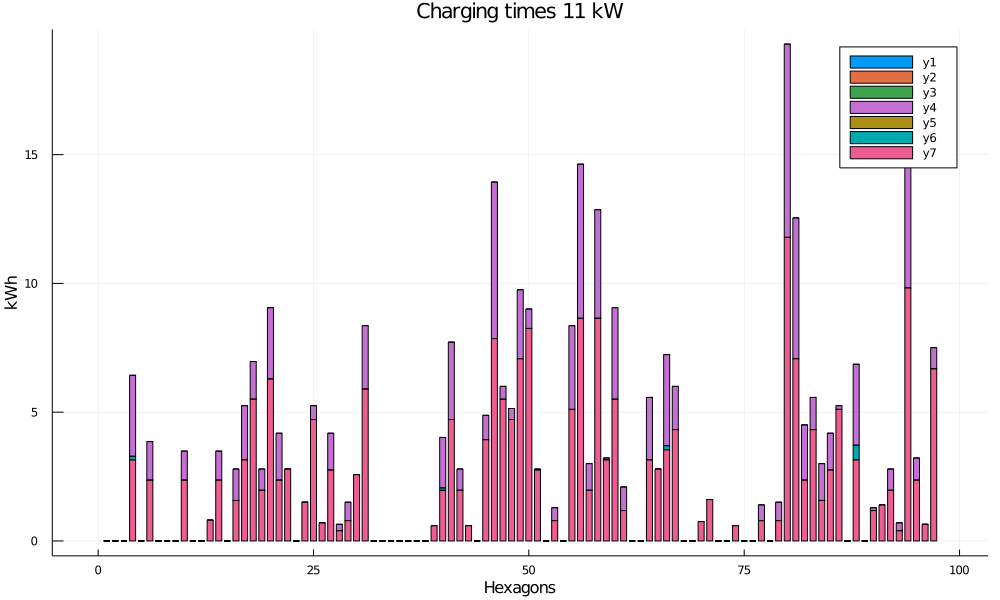

In [60]:
I, J, K, T = axes(value.(E_supplied))
charge_times = zeros(length(T), length(I))

for k in length(K)
    charge_times += transpose([value.(E_supplied[i,2,k,t]) for i in I, t in T])
end

charge_times = charge_times ./ length(K)


gr(size=(1000,600), legend=true)
groupedbar(charge_times',
            bar_position = :stack,
            bar_width=0.7,
            title = "Charging times 11 kW",
            xlabel = "Hexagons",
            ylabel = "kWh"
           )

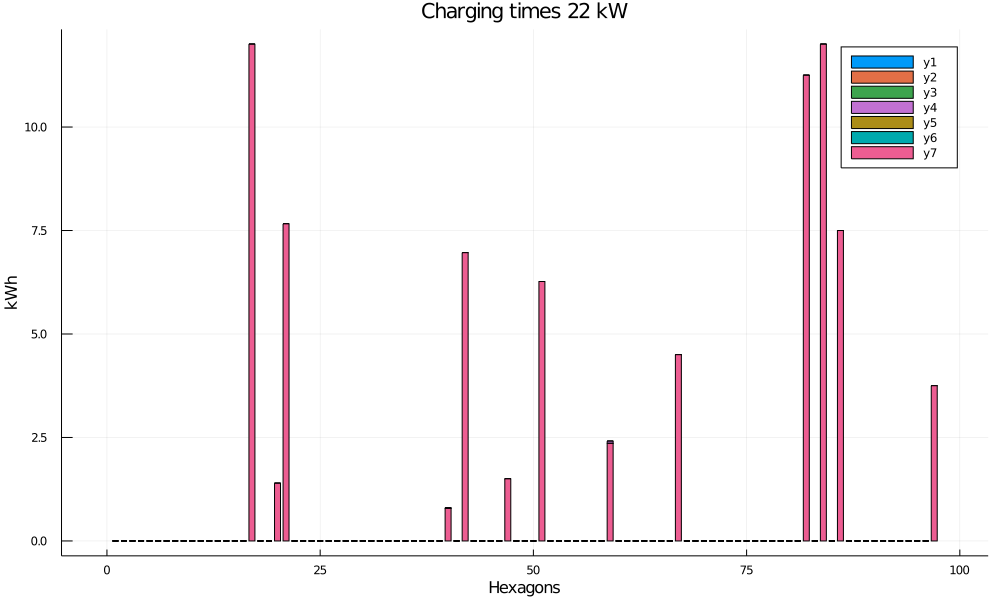

In [58]:
I, J, K, T = axes(value.(E_supplied))
charge_times = zeros(length(T), length(I))

for k in length(K)
    charge_times += transpose([value.(E_supplied[i,3,k,t]) for i in I, t in T])
end

charge_times = charge_times ./ length(K)

gr(size=(1000,600), legend=true)
groupedbar(charge_times',
            bar_position = :stack,
            bar_width=0.7,
            title = "Charging times 22 kW",
            xlabel = "Hexagons",
            ylabel = "kWh"
           )

In [61]:
CSV.write(
        string("charger_in_hex.csv"),
        DataFrame(charger_in_hex)
    )

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
    Dimension 2, [1, 2, 3]
And data, a 97×3 Array{Float64,2}:
 3.0   0.0   0.0
 0.0   1.0   0.0
 0.0   0.0   0.0
 0.0   8.0   0.0
 0.0   0.0   0.0
 0.0   6.0   0.0
 0.0   0.0   0.0
 0.0   0.0   0.0
 0.0   0.0   0.0
 0.0   6.0   0.0
 0.0   0.0   0.0
 1.0   0.0   0.0
 0.0   3.0   0.0
 ⋮          
 0.0  13.0  10.0
 0.0   0.0   0.0
 0.0   8.0   0.0
 2.0   0.0   0.0
 0.0   3.0   0.0
 0.0   5.0   0.0
 0.0   5.0   0.0
 0.0   1.0   0.0
 0.0  25.0   0.0
 0.0   6.0   0.0
 0.0   4.0   0.0
 0.0  17.0   5.0

## Run Sensitivity analysis 

### Opportunity cost 

opp_list = [0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]
charger_per_type_dict = Dict()
for opportunity_cost in opp_list
    charger_in_hex, E_not_supplied, res_total_cost, cvar = charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha_, beta)
    
    I, J = axes(charger_in_hex)
    xx = zeros(length(I),length(J))
    [xx[i,j] = charger_in_hex[i,j] for i in I, j in J]
    charger_per_type = sum(xx, dims=1)
    charger_per_type_dict[string(opportunity_cost)] = charger_per_type
    
end

charger_per_type_dict

auswertung = []
for i in opp_list
    values = charger_per_type_dict[string(i)]
    push!(auswertung, values)
end
auswertung

auswertung3 = vcat(auswertung...)

plot(opp_list',auswertung3, xlabel="Opportunity costs [€/kWh]", ylabel="total number of charging stations",label=["3.7 kW" "11 kW" "22 kW"])

In [11]:
op_cost_lst = [0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]
charger_op_cost_dict = Dict()
energy_op_cost_dict = Dict()
e_sup_op_cost_dict = Dict()
cars_sup_op_cost_dict = Dict()
cost_op_cost_dict = Dict()
cvar_op_cost_dict = Dict()
for opportunity_cost in op_cost_lst
    charger_in_hex, E_not_supplied, E_supplied, cars_supplied, res_total_cost, cvar= charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha_, beta)
    charger_op_cost_dict[opportunity_cost] = charger_in_hex
    energy_op_cost_dict[opportunity_cost] = value.(E_not_supplied)
    e_sup_op_cost_dict[opportunity_cost] = sum(value.(E_supplied))
    cars_sup_op_cost_dict[opportunity_cost] = sum(value.(cars_supplied))
    cost_op_cost_dict[opportunity_cost] = res_total_cost
    cvar_op_cost_dict[opportunity_cost] = cvar
end

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -1085.847000 after 0.02 sec. (9.24 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 24794 rows and 22302 columns.
MIP Presolve modified 1470 coefficients.
Aggregator did 1204 substitutions.
Reduced MIP has 52794 rows, 47430 columns, and 182476 nonzeros.
Reduced MIP has 867 binaries, 5599 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (128.02 ticks)
Probing time = 0.03 sec. (2.71 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1995 rows and 1809 columns.
Reduced MIP has 50799 rows, 45621 columns, and 175616 nonzeros.
Reduced MIP has 644 binaries, 5553 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (89.08 ticks)
Probing time = 0.03 sec. (2.59 ticks)
Clique table members: 189.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution ti

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -6515.082000 after 0.02 sec. (9.24 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 24794 rows and 22302 columns.
MIP Presolve modified 1470 coefficients.
Aggregator did 1204 substitutions.
Reduced MIP has 52794 rows, 47430 columns, and 182476 nonzeros.
Reduced MIP has 867 binaries, 5599 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (128.02 ticks)
Probing time = 0.03 sec. (2.71 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1995 rows and 1809 columns.
Reduced MIP has 50799 rows, 45621 columns, and 175616 nonzeros.
Reduced MIP has 644 binaries, 5553 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (89.09 ticks)
Probing time = 0.03 sec. (2.59 ticks)
Clique table members: 189.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution ti

In [12]:
for opportunity_cost in op_cost_lst
    println(opportunity_cost, 
        " Opportunity Cost: ", "charger_in_hex = ", sum(charger_op_cost_dict[opportunity_cost]),
        " / Energy not supplied = ", sum(energy_op_cost_dict[opportunity_cost]),
        " / Energy supplied = ", e_sup_op_cost_dict[opportunity_cost],
        " / Cars supplied = ", cars_sup_op_cost_dict[opportunity_cost],
        " / total cost = ", cost_op_cost_dict[opportunity_cost],
        " / Cvar = ", cvar_op_cost_dict[opportunity_cost]
    )
end

0.1 Opportunity Cost: charger_in_hex = 0.0 / Energy not supplied = 308794.5 / Energy supplied = 0.0 / Cars supplied = 0.0 / total cost = -1085.8470000000002 / Cvar = -1133.5500000000002
0.2 Opportunity Cost: charger_in_hex = 0.0 / Energy not supplied = 308794.5 / Energy supplied = 0.0 / Cars supplied = 0.0 / total cost = -2171.6940000000004 / Cvar = -2267.1000000000004
0.3 Opportunity Cost: charger_in_hex = 87.0 / Energy not supplied = 287275.5 / Energy supplied = 21519.00000000002 / Cars supplied = 1044.0 / total cost = -3255.920404723743 / Cvar = -3428.0124985540765
0.4 Opportunity Cost: charger_in_hex = 504.0 / Energy not supplied = 146847.0 / Energy supplied = 161947.4999999997 / Cars supplied = 8137.0 / total cost = -4046.7852119825548 / Cvar = -4273.081443030653
0.5 Opportunity Cost: charger_in_hex = 559.0 / Energy not supplied = 67333.5 / Energy supplied = 241460.9999999978 / Cars supplied = 12138.0 / total cost = -4406.119684231542 / Cvar = -4654.859239444766
0.6 Opportunity Co

In [13]:
for (key, value) in charger_op_cost_dict
    CSV.write(
        string("sensitivity/opportunity/charger_in_hex_",string(key),".csv"),
        DataFrame(value)
    )
end
for (key, value) in energy_op_cost_dict
    CSV.write(
        string("sensitivity/opportunity/E_not_supplied_",string(key),".csv"),
        DataFrame(value)
    )
end

CSV.write(
    string("sensitivity/opportunity/E_supplied.csv"),
    e_sup_op_cost_dict
)

CSV.write(
    string("sensitivity/opportunity/cars_supplied.csv"),
    cars_sup_op_cost_dict
)

CSV.write(
        string("sensitivity/opportunity/cost_dict.csv"),
        cost_op_cost_dict
    )
CSV.write(
        string("sensitivity/opportunity/cvar_dict.csv"),
        cvar_op_cost_dict
    )

"sensitivity/opportunity/cvar_dict.csv"

In [14]:
println(opportunity_cost)
println(hours)

37.47
["24", "1", "2", "3A", "4", "5", "6"]


### Charging hours 

In [15]:
hours_lst = [["22", "23", "24", "1", "2", "3", "4"],
            ["23", "24", "1", "2", "3", "4"],
            ["24", "1", "2", "3", "4"],
            ["1", "2", "3", "4"],
            ["2", "3", "4"],
            ["3", "4"]]
charger_hours_dict = Dict()
energy_hours_dict = Dict()
e_sup_hours_dict = Dict()
cars_sup_hours_dict = Dict()
cost_hours_dict = Dict()
cvar_hours_dict = Dict()
for hours in hours_lst
    charger_in_hex, E_not_supplied, E_supplied, cars_supplied, res_total_cost, cvar = charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha_, beta)
    charger_hours_dict[length(hours)] = charger_in_hex
    energy_hours_dict[length(hours)] = value.(E_not_supplied)
    e_sup_hours_dict[length(hours)] = sum(value.(E_supplied))
    cars_sup_hours_dict[length(hours)] = sum(value.(cars_supplied))
    cost_hours_dict[length(hours)] = res_total_cost
    cvar_hours_dict[length(hours)] = cvar
end

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -406866.870900 after 0.02 sec. (9.24 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 24794 rows and 22302 columns.
MIP Presolve modified 1470 coefficients.
Aggregator did 1204 substitutions.
Reduced MIP has 52794 rows, 47430 columns, and 182476 nonzeros.
Reduced MIP has 867 binaries, 5599 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (128.02 ticks)
Probing time = 0.03 sec. (2.71 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1995 rows and 1809 columns.
Reduced MIP has 50799 rows, 45621 columns, and 175616 nonzeros.
Reduced MIP has 644 binaries, 5553 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (89.09 ticks)
Probing time = 0.03 sec. (2.59 ticks)
Clique table members: 189.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution 

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -406866.870900 after 0.00 sec. (4.85 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 14546 rows and 12054 columns.
MIP Presolve modified 630 coefficients.
Reduced MIP has 31654 rows, 26290 columns, and 93100 nonzeros.
Reduced MIP has 1014 binaries, 6656 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (49.29 ticks)
Probing time = 0.01 sec. (1.96 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 11186 rows and 9305 columns.
Reduced MIP has 20468 rows, 16985 columns, and 60200 nonzeros.
Reduced MIP has 224 binaries, 4721 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (28.30 ticks)
Probing time = 0.00 sec. (1.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 9520 rows and 7900 columns.
Reduced MIP has 10948 rows, 9085 columns, and 32200 nonzeros.
Reduced MIP has 112 binaries, 2533 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (17.05 ticks)
Pro

In [16]:
for hours in hours_lst
    println(length(hours), " hours: ",
        "charger_in_hex = ", sum(charger_hours_dict[length(hours)]),
        " / Energy not supplied = ", sum(energy_hours_dict[length(hours)]),
        " / total cost = ", cost_hours_dict[length(hours)],
        " / Cvar = ", cvar_hours_dict[length(hours)]
    )
end

7 hours: charger_in_hex = 705.0 / Energy not supplied = 0.0 / total cost = -4538.501533256916 / Cvar = -4795.602706766917
6 hours: charger_in_hex = 705.0 / Energy not supplied = 3.552713678800501e-14 / total cost = -4549.147560872612 / Cvar = -4806.744256795836
5 hours: charger_in_hex = 705.0 / Energy not supplied = 3.552713678800501e-13 / total cost = -4597.029863297274 / Cvar = -4856.878632157316
4 hours: charger_in_hex = 705.0 / Energy not supplied = 5.684341886080802e-14 / total cost = -4703.520523378598 / Cvar = -4968.840002891844
3 hours: charger_in_hex = 705.0 / Energy not supplied = 1.4210854715202004e-14 / total cost = -4861.837668954027 / Cvar = -5132.397926547136
2 hours: charger_in_hex = 705.0 / Energy not supplied = 4.263256414560601e-14 / total cost = -5110.171175489059 / Cvar = -5385.804112203587


In [17]:
for (key, value) in charger_hours_dict
    CSV.write(
        string("sensitivity/hours/charger_in_hex_",string(key),".csv"),
        DataFrame(value)
    )
end
for (key, value) in energy_hours_dict
    CSV.write(
        string("sensitivity/hours/E_not_supplied_",string(key),".csv"),
        DataFrame(value)
    )
end

CSV.write(
    string("sensitivity/hours/E_supplied.csv"),
    e_sup_hours_dict
)

CSV.write(
    string("sensitivity/hours/cars_supplied.csv"),
    cars_sup_hours_dict
)

CSV.write(
        string("sensitivity/hours/cost_dict.csv"),
        cost_hours_dict
    )
CSV.write(
        string("sensitivity/hours/cvar_dict.csv"),
        cvar_hours_dict
    )

"sensitivity/hours/cvar_dict.csv"

In [18]:
println(opportunity_cost)
println(hours)

37.47
["24", "1", "2", "3A", "4", "5", "6"]


In [19]:
beta_lst = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
charger_beta_dict = Dict()
energy_beta_dict = Dict()
e_sup_beta_dict = Dict()
cars_sup_beta_dict = Dict()
cost_beta_dict = Dict()
cvar_beta_dict = Dict()
for beta in beta_lst
    charger_in_hex, E_not_supplied, E_supplied, cars_supplied, res_total_cost, cvar= charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha_, beta)
    charger_beta_dict[beta] = charger_in_hex
    energy_beta_dict[beta] = value.(E_not_supplied)
    e_sup_beta_dict[beta] = sum(value.(E_supplied))
    cars_sup_beta_dict[beta] = sum(value.(cars_supplied))
    cost_beta_dict[beta] = res_total_cost
    cvar_beta_dict[beta] = cvar
end

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -406866.870900 after 0.00 sec. (9.24 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 24794 rows and 22302 columns.
MIP Presolve modified 1470 coefficients.
Aggregator did 1204 substitutions.
Reduced MIP has 52794 rows, 47430 columns, and 182476 nonzeros.
Reduced MIP has 867 binaries, 5599 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (128.02 ticks)
Probing time = 0.03 sec. (2.71 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1995 rows and 1809 columns.
Reduced MIP has 50799 rows, 45621 columns, and 175616 nonzeros.
Reduced MIP has 644 binaries, 5553 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (89.09 ticks)
Probing time = 0.03 sec. (2.59 ticks)
Clique table members: 189.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution 

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -424741.185000 after 0.02 sec. (9.36 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 24766 rows and 22273 columns.
MIP Presolve modified 42434 coefficients.
Aggregator did 1204 substitutions.
Reduced MIP has 52822 rows, 47459 columns, and 224126 nonzeros.
Reduced MIP has 867 binaries, 5599 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.17 sec. (263.98 ticks)
Probing time = 0.03 sec. (3.00 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 52822 rows, 47459 columns, and 224126 nonzeros.
Reduced MIP has 867 binaries, 5599 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (106.74 ticks)
Probing time = 0.05 sec. (3.07 ticks)
Clique table members: 294.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 3.41 sec. (1482.65 ticks)

        Nodes   

In [20]:
for beta in beta_lst
    println(beta, 
        " beta: ", "charger_in_hex = ", sum(charger_beta_dict[beta]),
        " / Energy not supplied = ", sum(energy_beta_dict[beta]),
        " / total cost = ", cost_beta_dict[beta],
        " / Cvar = ", cvar_beta_dict[beta]
    )
end

0.0 beta: charger_in_hex = 705.0 / Energy not supplied = 0.0 / total cost = -4538.501533256916 / Cvar = -4795.602706766917
0.2 beta: charger_in_hex = 705.0 / Energy not supplied = 0.0 / total cost = -4538.533430817807 / Cvar = -4727.387953752256
0.4 beta: charger_in_hex = 705.0 / Energy not supplied = 0.0 / total cost = -4538.5319977126 / Cvar = -4727.315711830717
0.6 beta: charger_in_hex = 705.0 / Energy not supplied = 0.0 / total cost = -4538.594008920895 / Cvar = -4727.26750493562
0.8 beta: charger_in_hex = 705.0 / Energy not supplied = 0.0 / total cost = -4538.711256025486 / Cvar = -4727.18318584778
1.0 beta: charger_in_hex = 705.0 / Energy not supplied = 256.50000000000006 / total cost = -4561.187197750148 / Cvar = -4727.124732197274


In [21]:
for (key, value) in charger_beta_dict
    CSV.write(
        string("sensitivity/beta/charger_in_hex_",string(key),".csv"),
        DataFrame(value)
    )
end
for (key, value) in energy_beta_dict
    CSV.write(
        string("sensitivity/beta/E_not_supplied_",string(key),".csv"),
        DataFrame(value)
    )
end

CSV.write(
    string("sensitivity/beta/E_supplied.csv"),
    e_sup_beta_dict
)

CSV.write(
    string("sensitivity/beta/cars_supplied.csv"),
    cars_sup_beta_dict
)

CSV.write(
        string("sensitivity/beta/cost_dict.csv"),
        cost_beta_dict
    )
CSV.write(
        string("sensitivity/beta/cvar_dict.csv"),
        cvar_beta_dict
    )

"sensitivity/beta/cvar_dict.csv"

charger_cost = [600, 400, 100]# investment cost for charger 3 kW, 7 kW und 11 kW in €/kW
charger_cost_delta = 600
charger_cost_dict = Dict()
energy_dict = Dict()
for i in range(0, step=100, stop=charger_cost_delta)
    charger_in_hex, x_charger, E_not_supplied, = charger_siting(
        SOC, hexagons, hours, car_kWh, demand_cars, demand_kWh, prices,
        probability, P, charger_cost.+i, opportunity_cost, alpha, beta)
    charger_cost_dict[charger_cost.+i] = charger_in_hex
    energy_dict[charger_cost.+i] = value.(E_not_supplied)
end

for key in keys(charger_cost_dict)
    println(key, " Charger Cost: ", "charger_in_hex = ", sum(charger_cost_dict[key]),
        " / Energy not supplied = ", sum(energy_dict[key]))
end